In [2]:
import os
import time
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
import albumentations
import matplotlib.pyplot as plt
from pylab import rcParams
import timm
import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold


In [3]:
class CFG:
    backbone = 'tf_efficientnetv2_s_in21ft1k'
    device = 'cuda'
    image_size = 224
    n_slice_per_c = 15
    in_chans = 6
    out_dim = 1
    drop_rate = 0.
    drop_rate_last = 0.3
    drop_path_rate = 0.
    p_rand_order_v1 = 0.2
    p_mixup = 0.1
    # init_lr = 23e-5
    init_lr = 10e-5
    eta_min = 23e-6
    n_epochs = 10
    batch_size = 16
    num_workers = 4
    use_amp = True
    dropout = 0.1

In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(CFG.image_size, CFG.image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    # # albumentations.RandomBrightness(limit=0.1, p=0.7),
    # albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    # albumentations.OneOf([
    #     albumentations.MotionBlur(blur_limit=3),
    #     albumentations.MedianBlur(blur_limit=3),
    #     albumentations.GaussianBlur(blur_limit=3),
    #     albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    # ], p=0.5),
    # albumentations.OneOf([
    #     albumentations.OpticalDistortion(distort_limit=1.),
    #     albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    # ], p=0.5),

    # albumentations.Cutout(max_h_size=int(CFG.image_size * 0.5), max_w_size=int(CFG.image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(CFG.image_size, CFG.image_size),
])

len 23419


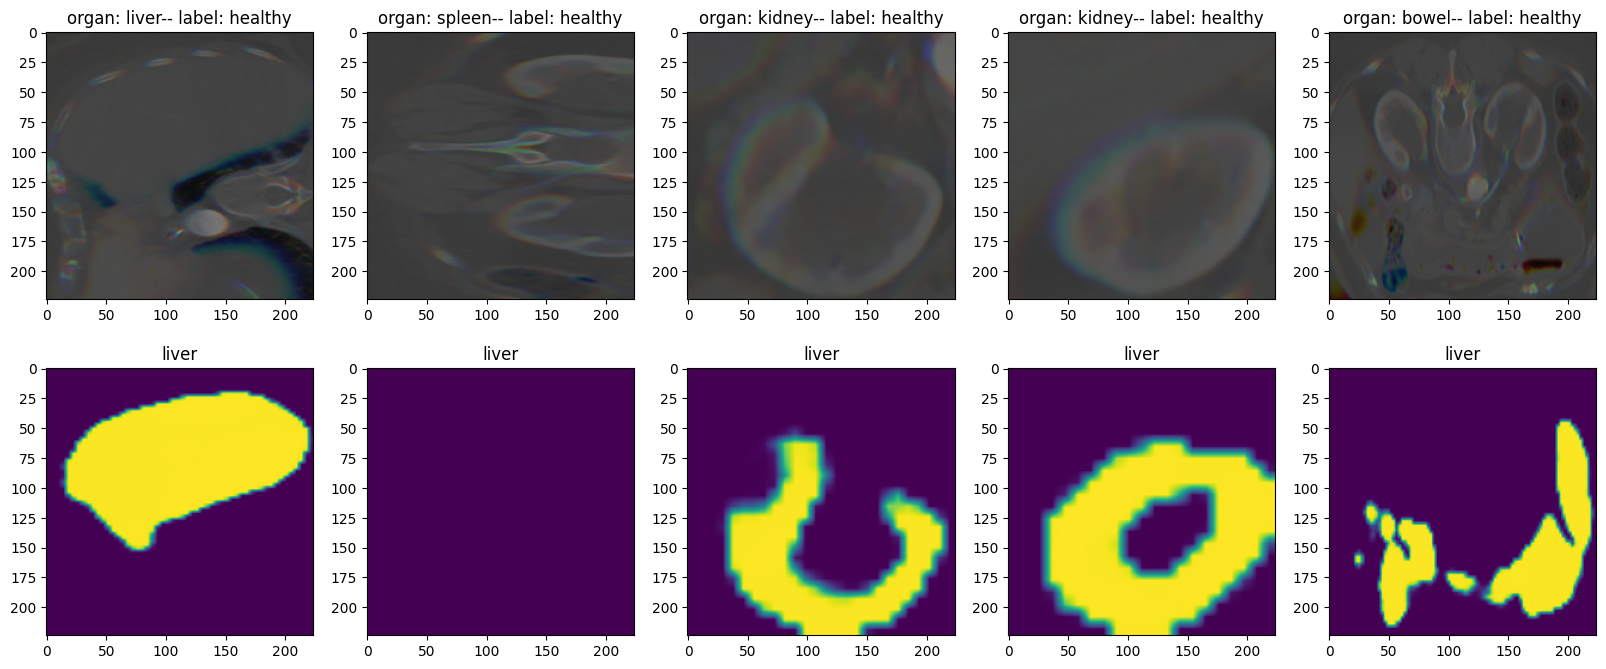

In [5]:
class ClsDataset(Dataset):
    def __init__(self, df, mode, transform):
        self.df = df
        self.mode = mode
        self.transform = transform
        self.map_cls = {0: 'liver', 1: 'spleen', 2: 'kidney', 3: 'kidney', 4: 'bowel'}

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # print('info', self.df.loc[idx])
        patient_id = int(row.patient_id)
        study_id = int(row.study_id)
        cid = int(row.cid)
        #print(f"patient: {patient_id} with series: {study_id}")
        raw_label = self.map_cls[cid]
        # print(f'idx {idx} - name label: {label}')
        label = self.df.iloc[idx, self.df.columns.get_loc(raw_label)]
   
        images = []
        
        for ind in list(range(CFG.n_slice_per_c)):
            filepath = os.path.join('data/stage1/crop', f'{patient_id}_{study_id}_{cid}_{ind}.npy')
            image = np.load(filepath)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)
        images = torch.tensor(images).float()
        # labels = torch.tensor([label] * CFG.n_slice_per_c).float()
        labels = torch.tensor(label).float()
        if random.random() < CFG.p_rand_order_v1:
            indices = torch.randperm(images.size(0))
            images = images[indices]
            # labels = labels[indices]
        # print('lbl', labels)
        # indices = torch.randperm(images.size(0))
        # images = images[indices]
        return images, labels, raw_label


map_cls = {0: 'liver', 1: 'spleen', 2: 'kidney', 3: 'kidney', 4: 'bowel'}
mapping = {0: 'healthy', 1: 'injury'}
rcParams['figure.figsize'] = 20,8
df = pd.read_csv('data/stage1/train_cls.csv')
print('len', len(df))
df_show = df
dataset_show = ClsDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)


f, axarr = plt.subplots(2,5)
slice_idx = 4
for p in range(5):
    idx = p + 5 * 30
    imgs, lbl, raw_lbl = dataset_show[idx]
    imgs = imgs[slice_idx]
    lbl = lbl
    lbl = lbl.item()
    axarr[0, p].imshow(imgs[1:4].permute(1, 2, 0))
    axarr[0, p].set_title(f"organ: {raw_lbl}-- label: {mapping[lbl]}")
    axarr[1, p].imshow(imgs[-1])
    axarr[1, p].set_title(map_cls[lbl])



In [5]:
# f, axarr = plt.subplots(2,5)
# slice_idx = 4
# for p in range(5):
#     idx = p + 5 * 10
#     imgs, lbl, raw_lbl = dataset_show[idx]
#     imgs = imgs[slice_idx]
#     lbl = lbl[slice_idx]
#     lbl = lbl.item()
#     axarr[0, p].imshow(imgs[1:4].permute(1, 2, 0))
#     axarr[0, p].set_title(f"organ: {raw_lbl}-- label: {mapping[lbl]}")
#     axarr[1, p].imshow(imgs[-1])
#     axarr[1, p].set_title(map_cls[lbl])

In [5]:
sample = next(iter(loader_show))
label = sample[1]
print(label)
print(label.size())

tensor([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
torch.Size([16])


In [6]:
from itertools import repeat


class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim
        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x

class TimmModel2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super().__init__()
        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )
        
        hdim = self.encoder.conv_head.out_channels
        self.encoder.classifier = nn.Identity()
        
        self.spatialdropout = SpatialDropout(CFG.dropout)
        self.gru = nn.GRU(hdim, 256, 2, batch_first=True, bidirectional=True)
        self.mlp_attention_layer = MLPAttentionNetwork(512)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(CFG.drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, CFG.out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_per_c, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = self.spatialdropout(feat)
        feat = feat.view(bs, CFG.n_slice_per_c, -1)
        # print('feat', feat.size())
        feat, _ = self.gru(feat)
        # print(feat.size())
        feat = self.mlp_attention_layer(feat) # [bs, 512]
        # feat = feat.contiguous().view(bs * CFG.n_slice_per_c, -1)
        # print('mlp', feat.size())
        feat = self.head(feat)
        # feat = feat.view(bs, CFG.n_slice_per_c).contiguous()
        # feat = self.mean_layer(feat)
        feat = feat.view(bs, -1)
        return feat


m = TimmModel2(CFG.backbone)
out = m(torch.rand(2, CFG.n_slice_per_c, CFG.in_chans, CFG.image_size, CFG.image_size))
print(out.size())
print('preds', out.sigmoid())  

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


torch.Size([2, 1])
preds tensor([[0.5671],
        [0.5046]], grad_fn=<SigmoidBackward0>)


In [7]:
# class TimmModel(nn.Module):
#     def __init__(self, backbone, pretrained=False):
#         super(TimmModel, self).__init__()

#         self.encoder = timm.create_model(
#             backbone,
#             in_chans=CFG.in_chans,
#             num_classes=CFG.out_dim,
#             features_only=False,
#             drop_rate=CFG.drop_rate,
#             drop_path_rate=CFG.drop_path_rate,
#             pretrained=pretrained
#         )

#         if 'efficient' in backbone:
#             hdim = self.encoder.conv_head.out_channels
#             self.encoder.classifier = nn.Identity()
#         elif 'convnext' in backbone:
#             hdim = self.encoder.head.fc.in_features
#             self.encoder.head.fc = nn.Identity()


#         self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
#         self.head = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(CFG.drop_rate_last),
#             nn.LeakyReLU(0.1),
#             nn.Linear(256, CFG.out_dim),
#         )
#         # self.mean_layer = nn.Sequential(
#         #     nn.AdaptiveAvgPool2d((1, 1)),  # AdaptiveAvgPool2d to perform mean reduction
#         #     nn.Flatten()  # Flatten the output
#         # )

#     def forward(self, x):  # (bs, nslice, ch, sz, sz)
#         bs = x.shape[0]
#         x = x.view(bs * CFG.n_slice_per_c, CFG.in_chans, CFG.image_size, CFG.image_size)
#         feat = self.encoder(x)
#         feat = feat.view(bs, CFG.n_slice_per_c, -1)
#         feat, _ = self.lstm(feat)
#         feat = feat.contiguous().view(bs * CFG.n_slice_per_c, -1)
#         feat = self.head(feat)
#         feat = feat.view(bs, CFG.n_slice_per_c).contiguous()
#         # feat = self.mean_layer(feat)
#         return feat


# m = TimmModel(CFG.backbone)
# out = m(torch.rand(2, CFG.n_slice_per_c, CFG.in_chans, CFG.image_size, CFG.image_size))
# print(out.size())
# print('preds', out.sigmoid())

In [8]:
bce = nn.BCEWithLogitsLoss(reduction='none')
bce_v2 = nn.BCELoss()

def criterion(logits, targets, activated=False):
    # print('debug logits', logits.size())
    # print('debug targets', targets.size())
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 3.
    norm = torch.ones(logits.view(-1).shape[0]).to(CFG.device)
    norm[targets.view(-1) > 0] *= 3.
    return losses.sum() / norm.sum()


def criterion_v2(logits, targets):
    # logits: #[batch, n_slice]
    # target: # [batch]
    # logits = torch.sigmoid(logits)
    logits = torch.mean(logits, dim=1)
    loss = bce(logits, targets)
    return loss.mean()

In [9]:
from sklearn.metrics import roc_auc_score
import random

def calculate_auc(gts, outputs):
    gts = [tensor.detach().cpu().numpy() for tensor in gts]
    outputs = [tensor.sigmoid().detach().cpu().numpy() for tensor in outputs]
    # gts = [np.mean(gt, axis=1) for gt in gts]
    # outputs = [np.mean(output, axis=1) for output in outputs]
    print('gts', gts)
    print('outputs', outputs)
    total_auc_score = []
    for gt, output in zip(gts, outputs):
        try:
            auc_score = roc_auc_score(gt, output)
            total_auc_score.append(auc_score)
        except:
            # print('debug', gt)
            continue
    # print(total_auc_score)
    return sum(total_auc_score) / len(total_auc_score)


def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets, raw_label in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets, raw_label in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    auc_score = calculate_auc(gts, outputs)
    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    
    valid_loss = criterion(outputs, gts).item()

    return valid_loss, auc_score

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unab

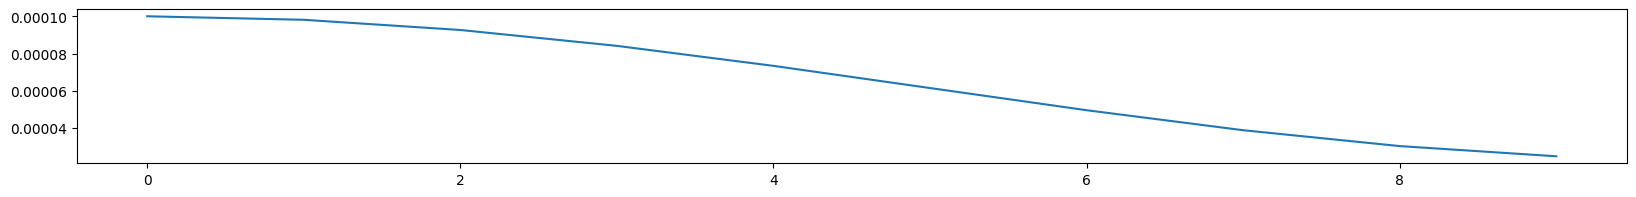

In [10]:
from pylab import rcParams
import matplotlib.pyplot as plt
import torch.optim as optim
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=CFG.init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

lrs = []
for epoch in range(1, CFG.n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)


In [ ]:
log_dir = './logs'
model_dir = './weights'
DEBUG = False

def run(fold):
    df = pd.read_csv('data/stage1/train_cls.csv')
    log_file = os.path.join(log_dir, f'filter_stage2_{CFG.backbone}_fold{fold}.txt')
    model_file = os.path.join(model_dir, f'filter_stage2_{CFG.backbone}_fold{fold}_best.pth')
    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = ClsDataset(train_, 'train', transform=transforms_train)
    dataset_valid = ClsDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = TimmModel2(CFG.backbone, pretrained=True)
    model = model.to(CFG.device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None
    metric_best = 0
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        # train_loss = 0
        valid_loss, auc_score = valid_func(model, loader_valid)
        metric = auc_score

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(auc_score):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
run(4)

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


18735 4684
Sun Oct 15 20:50:03 2023 Epoch: 1


smth:0.3666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [19:37<00:00,  4.02s/it]


gts [array([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 

smth:0.3973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [20:05<00:00,  4.11s/it]


gts [array([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 

smth:0.3739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [19:33<00:00,  4.01s/it]


gts [array([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 

smth:0.3248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [19:32<00:00,  4.00s/it]


gts [array([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 

smth:0.2807:  21%|█████████████████████████▊                                                                                                  | 244/1170 [16:22<36:55,  2.39s/it]

In [ ]:
# prediction
patient_id = 10937
study_id = 12039
all = []
for cid in range(5):
    images = []
    for nid in range(15):
        image = np.load(f"data/stage1/crop/{patient_id}_{study_id}_{cid}_{nid}.npy")
        images.append(image)
    images = torch.stack(image, 0)
    all.append(images)
all = torch.stack(all, 0)
print(all.size())